## Imports

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3, venn2
from upsetplot import from_contents, UpSet
import numpy as np
from itertools import combinations
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

## Load Data

In [15]:
# load the final dataframe
combined_terms_final_df = pd.read_csv("data/csv/combined_terms_final.csv")

combined_terms_final_df.head()

,date,topic,text,term,clean_text,bertopic_topic,bertopic_prob,is_bertopic,lda_topic,lda_prob,...,nmf_topic,nmf_prob,is_nmf,top2vec_topic,top2vec_score,is_top2vec,is_full,is_shortened,keywords_full,keywords_shortened
0,07-05-1999,1. VOTES,President . – We shall now move on to the vote...,94_99,shall votes regulation ecsc ec euratom incorpo...,11,0.155931,False,85,0.246812,...,99,0.021814,False,16,0.836422,False,False,False,[],[]
1,07-05-1999,2. Potato starch,President . – The next item is the proposal fo...,94_99,regulation amending regulation ec establishing...,4,0.273608,False,17,0.404205,...,45,0.014470,False,6,0.790973,False,False,False,[],[]
2,07-05-1999,3. Hannover 2000,President . – The next item is the report (A4‐...,94_99,hoppenstedt culture youth education media comm...,39,0.194263,False,62,0.431773,...,78,0.042771,False,69,0.673040,False,False,False,[],[]
3,07-05-1999,4. European textiles market,President . – The next item is the joint debat...,94_99,following b ferrer peijs chanterie group peopl...,235,1.000000,False,85,0.289002,...,99,0.056262,False,180,0.908692,False,False,False,[],[]
4,06-05-1999,1. Approval of the Minutes,President . – The Minutes of yesterday's sitti...,94_99,distributed spencer ppe chairman foreign affai...,-1,0.000000,False,85,0.670585,...,99,0.074247,False,10,0.696468,False,False,False,[],[]


In [16]:
df = combined_terms_final_df.copy()

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23408 entries, 0 to 23407
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                23408 non-null  object 
 1   topic               23408 non-null  object 
 2   text                23408 non-null  object 
 3   term                23408 non-null  object 
 4   clean_text          23408 non-null  object 
 5   bertopic_topic      23408 non-null  int64  
 6   bertopic_prob       23408 non-null  float64
 7   is_bertopic         23408 non-null  bool   
 8   lda_topic           23408 non-null  int64  
 9   lda_prob            23408 non-null  float64
 10  is_lda              23408 non-null  bool   
 11  nmf_topic           23408 non-null  int64  
 12  nmf_prob            23408 non-null  float64
 13  is_nmf              23408 non-null  bool   
 14  top2vec_topic       23408 non-null  int64  
 15  top2vec_score       23408 non-null  float64
 16  is_t

## Evaluation

### Basic Statistics

In [18]:
print(df[['is_full', 'is_shortened', 'is_bertopic', 'is_lda', 'is_nmf', 'is_top2vec']].dtypes)
print(df[['is_full', 'is_shortened', 'is_bertopic', 'is_lda', 'is_nmf', 'is_top2vec']].head())

is_full         bool
is_shortened    bool
is_bertopic     bool
is_lda          bool
is_nmf          bool
is_top2vec      bool
dtype: object
   is_full  is_shortened  is_bertopic  is_lda  is_nmf  is_top2vec
0    False         False        False   False   False       False
1    False         False        False   False   False       False
2    False         False        False   False   False       False
3    False         False        False   False   False       False
4    False         False        False   False   False       False


In [19]:
approaches = {
    'Keyword (Full)': 'is_full',
    'Keyword (Shortened)': 'is_shortened',
    'BERTopic': 'is_bertopic',
    'LDA': 'is_lda',
    'NMF': 'is_nmf',
    'Top2Vec': 'is_top2vec'
}

print("\n=== Transport Documents Count by Approach ===")
for name, col in approaches.items():
    count = df[col].sum()
    percentage = (count / len(df)) * 100
    print(f"{name:20s}: {count:6d} ({percentage:.2f}%)")


=== Transport Documents Count by Approach ===
Keyword (Full)      :   2845 (12.15%)
Keyword (Shortened) :    187 (0.80%)
BERTopic            :    536 (2.29%)
LDA                 :    442 (1.89%)
NMF                 :    592 (2.53%)
Top2Vec             :    672 (2.87%)


The approach with the shortened keyword list provides the most strict filtering, while using the full keyword list identifies the highest amount of transcripts as transport related. The four topic modeling models have a relatively similar performance, ranging from 1.89% to 2.87% of total transcripts marked as transport related.


The approach with the full keywords list will not be included in further analysis since it is determined that it is the least valid approach, as it identifies too many transcripts as transport related, compared to all the other approaches.

### Agreement and Consensus Analysis

In [23]:
approaches_no_full = {k: v for k, v in approaches.items() if k != 'Keyword (Full)'}

In [24]:
# Pairwise agreement between approaches (excluding Keyword Full)

print("\n=== Pairwise Agreement (excluding Keyword Full) ===")
for (name1, col1), (name2, col2) in combinations(approaches_no_full.items(), 2):
    both = (df[col1] & df[col2]).sum()
    only_1 = (df[col1] & ~df[col2]).sum()
    only_2 = (~df[col1] & df[col2]).sum()
    neither = (~df[col1] & ~df[col2]).sum()
    
    jaccard = both / (both + only_1 + only_2) if (both + only_1 + only_2) > 0 else 0
    
    print(f"\n{name1} & {name2}:")
    print(f"  Both agree (transport):     {both:5d}")
    print(f"  Only {name1:20s}: {only_1:5d}")
    print(f"  Only {name2:20s}: {only_2:5d}")
    print(f"  Jaccard similarity:         {jaccard:.3f}")


=== Pairwise Agreement (excluding Keyword Full) ===

Keyword (Shortened) & BERTopic:
  Both agree (transport):        97
  Only Keyword (Shortened) :    90
  Only BERTopic            :   439
  Jaccard similarity:         0.155

Keyword (Shortened) & LDA:
  Both agree (transport):       106
  Only Keyword (Shortened) :    81
  Only LDA                 :   336
  Jaccard similarity:         0.203

Keyword (Shortened) & NMF:
  Both agree (transport):       135
  Only Keyword (Shortened) :    52
  Only NMF                 :   457
  Jaccard similarity:         0.210

Keyword (Shortened) & Top2Vec:
  Both agree (transport):       132
  Only Keyword (Shortened) :    55
  Only Top2Vec             :   540
  Jaccard similarity:         0.182

BERTopic & LDA:
  Both agree (transport):       244
  Only BERTopic            :   292
  Only LDA                 :   198
  Jaccard similarity:         0.332

BERTopic & NMF:
  Both agree (transport):       324
  Only BERTopic            :   212
  Only NMF 

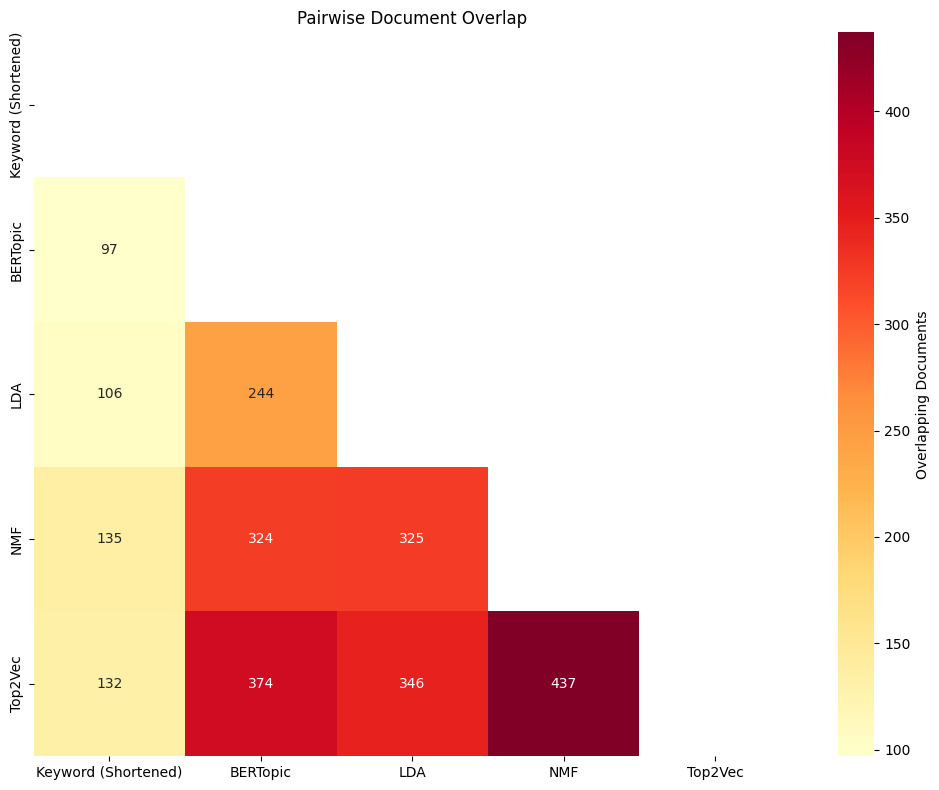

In [29]:
overlap_matrix = pd.DataFrame(index=approaches_no_full.keys(), columns=approaches_no_full.keys(), dtype=float)

for name1, col1 in approaches_no_full.items():
    for name2, col2 in approaches_no_full.items():
        if name1 != name2:
            overlap = (df[col1] & df[col2]).sum()
            overlap_matrix.loc[name1, name2] = overlap
mask = np.triu(np.ones_like(overlap_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(overlap_matrix.astype(float), mask=mask, annot=True, fmt='.0f', 
            cmap='YlOrRd', cbar_kws={'label': 'Overlapping Documents'})
plt.title('Pairwise Document Overlap')
plt.tight_layout()
plt.show()

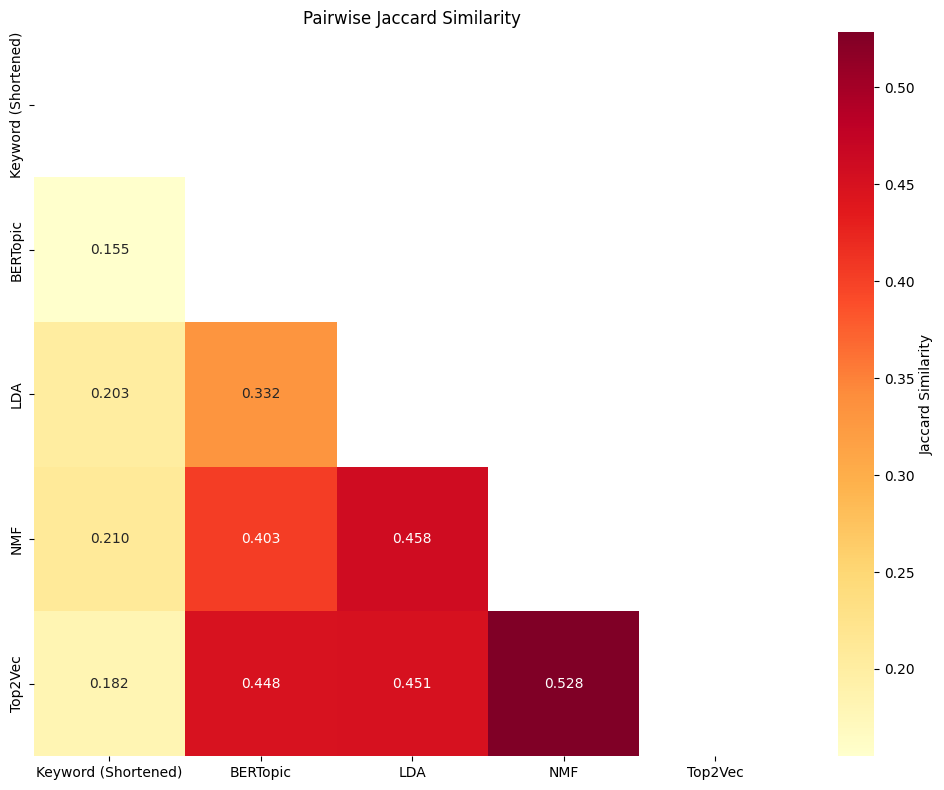

In [32]:
# Create Jaccard similarity matrix
jaccard_matrix = pd.DataFrame(index=approaches_no_full.keys(), columns=approaches_no_full.keys(), dtype=float)

for name1, col1 in approaches_no_full.items():
    for name2, col2 in approaches_no_full.items():
        if name1 != name2:
            intersection = (df[col1] & df[col2]).sum()
            union = (df[col1] | df[col2]).sum()
            jaccard = intersection / union if union > 0 else 0
            jaccard_matrix.loc[name1, name2] = jaccard
mask = np.triu(np.ones_like(jaccard_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(jaccard_matrix.astype(float), mask=mask, annot=True, fmt='.3f', 
            cmap='YlOrRd', cbar_kws={'label': 'Jaccard Similarity'})
plt.title('Pairwise Jaccard Similarity')
plt.tight_layout()
plt.show()

In [25]:
df['num_approaches_agree'] = df[list(approaches_no_full.values())].sum(axis=1)

print("\n=== Consensus Distribution (5 approaches, excluding Keyword Full) ===")
consensus_dist = df['num_approaches_agree'].value_counts().sort_index()
for num_agree, count in consensus_dist.items():
    percentage = (count / len(df)) * 100
    print(f"{num_agree} approaches agree: {count:5d} documents ({percentage:.2f}%)")

# Documents where all approaches agree
all_agree = df[df['num_approaches_agree'] == 5]
print(f"\nDocuments where ALL 5 approaches agree: {len(all_agree)} ({(len(all_agree)/len(df))*100:.2f}%)")

# Documents where at least 3 approaches agree
majority_agree = df[df['num_approaches_agree'] >= 3]
print(f"Documents where ≥3 approaches agree: {len(majority_agree)} ({(len(majority_agree)/len(df))*100:.2f}%)")


=== Consensus Distribution (5 approaches, excluding Keyword Full) ===
0 approaches agree: 22406 documents (95.72%)
1 approaches agree:   298 documents (1.27%)
2 approaches agree:   287 documents (1.23%)
3 approaches agree:   175 documents (0.75%)
4 approaches agree:   178 documents (0.76%)
5 approaches agree:    64 documents (0.27%)

Documents where ALL 5 approaches agree: 64 (0.27%)
Documents where ≥3 approaches agree: 417 (1.78%)


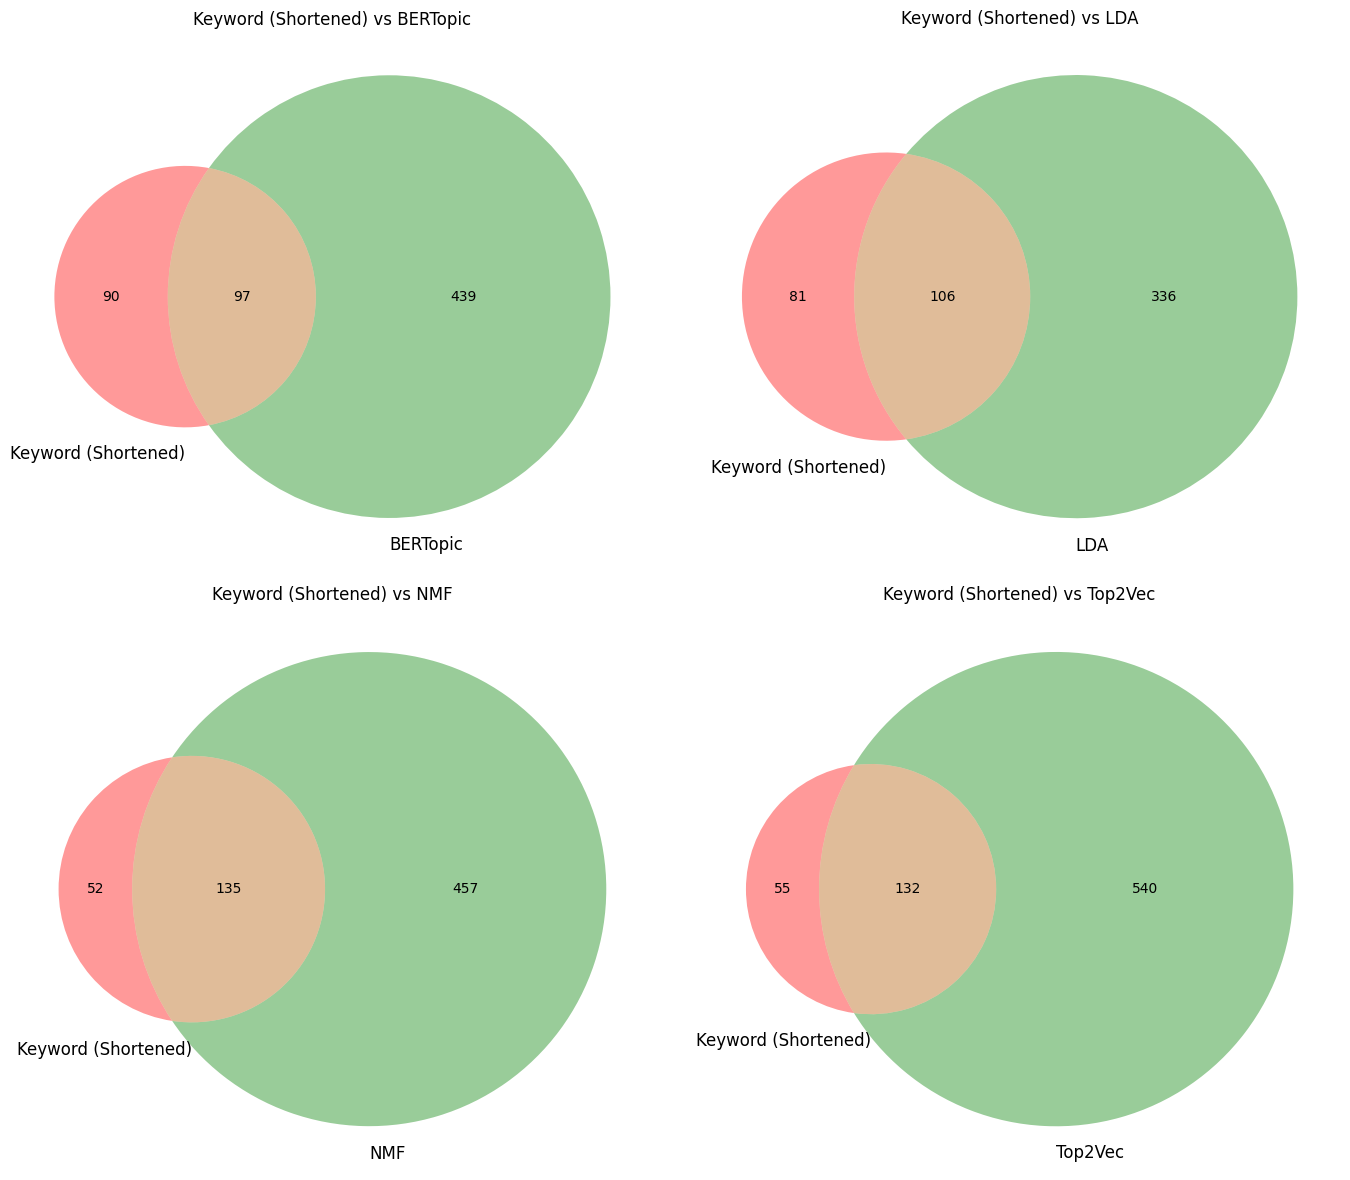

In [45]:
# Compare Keyword (Shortened) with each topic model
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

topic_models = ['BERTopic', 'LDA', 'NMF', 'Top2Vec']
columns = ['is_bertopic', 'is_lda', 'is_nmf', 'is_top2vec']

for idx, (model_name, col) in enumerate(zip(topic_models, columns)):
    venn2([
        set(df[df['is_shortened']].index),
        set(df[df[col]].index)
    ], set_labels=('Keyword (Shortened)', model_name), ax=axes[idx])
    axes[idx].set_title(f'Keyword (Shortened) vs {model_name}')

plt.tight_layout()
plt.show()

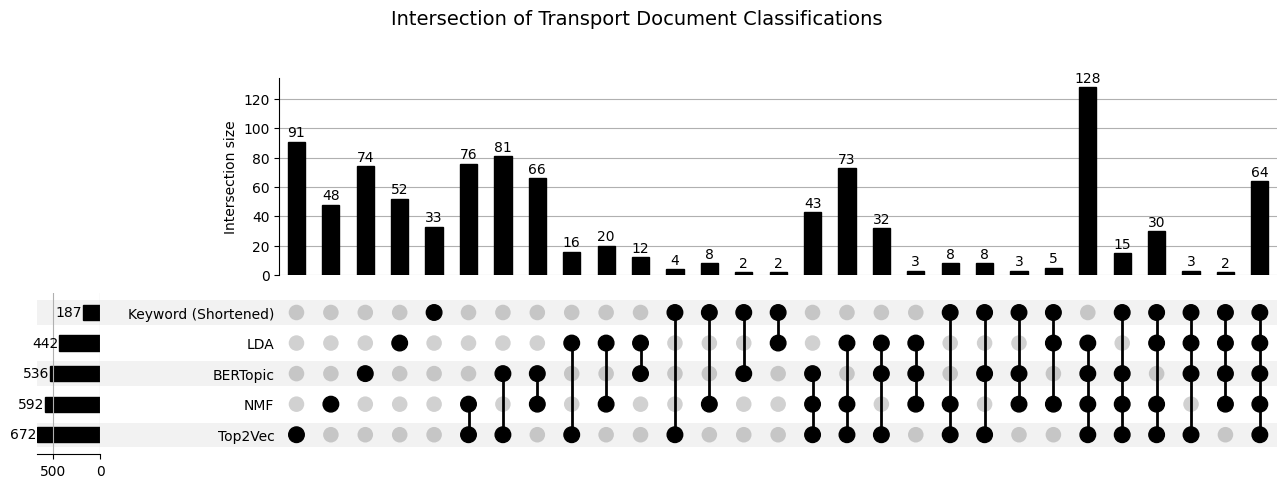

In [43]:
data_dict = {
    'Keyword (Shortened)': set(df[df['is_shortened']].index),
    'BERTopic': set(df[df['is_bertopic']].index),
    'LDA': set(df[df['is_lda']].index),
    'NMF': set(df[df['is_nmf']].index),
    'Top2Vec': set(df[df['is_top2vec']].index)
}

# Create UpSet plot
upset_data = from_contents(data_dict)
upset = UpSet(upset_data, subset_size='count', show_counts=True)

upset.plot()
plt.suptitle('Intersection of Transport Document Classifications', y=1.02, fontsize=14)
plt.show()

### Metrics

In this part, the results from the keyword matching based approach (with shortened keyword list) will be viewed as ground truth, so that performance metrics can be computed for the models.

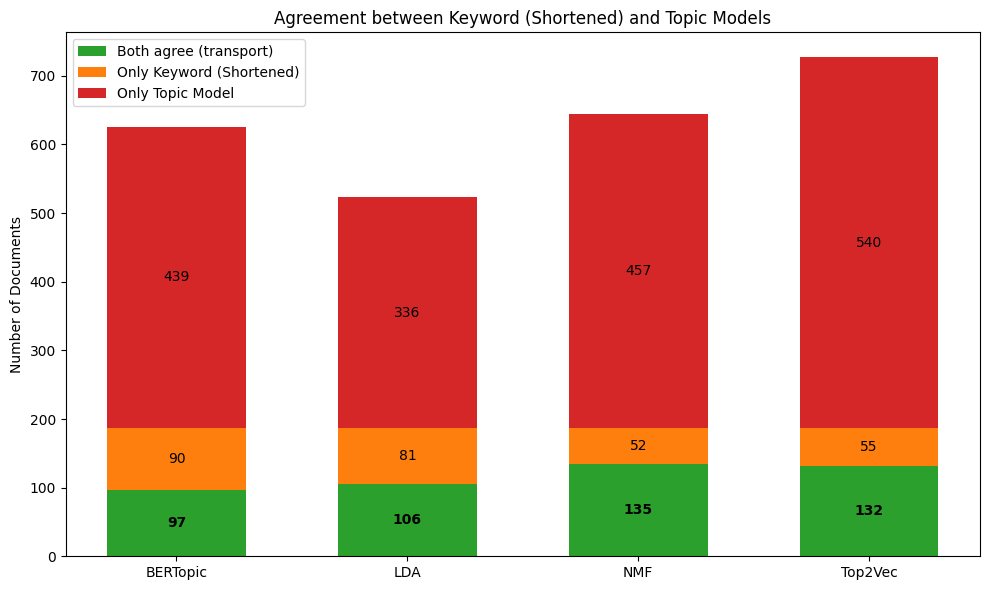

In [33]:
# Prepare data for stacked bar chart
pairwise_data = {
    'BERTopic': {'Both': 97, 'Only Keyword': 90, 'Only Model': 439},
    'LDA': {'Both': 106, 'Only Keyword': 81, 'Only Model': 336},
    'NMF': {'Both': 135, 'Only Keyword': 52, 'Only Model': 457},
    'Top2Vec': {'Both': 132, 'Only Keyword': 55, 'Only Model': 540}
}

fig, ax = plt.subplots(figsize=(10, 6))

models = list(pairwise_data.keys())
both = [pairwise_data[m]['Both'] for m in models]
only_keyword = [pairwise_data[m]['Only Keyword'] for m in models]
only_model = [pairwise_data[m]['Only Model'] for m in models]

x = np.arange(len(models))
width = 0.6

p1 = ax.bar(x, both, width, label='Both agree (transport)', color='#2ca02c')
p2 = ax.bar(x, only_keyword, width, bottom=both, label='Only Keyword (Shortened)', color='#ff7f0e')
p3 = ax.bar(x, only_model, width, bottom=np.array(both) + np.array(only_keyword), 
            label='Only Topic Model', color='#d62728')

ax.set_ylabel('Number of Documents')
ax.set_title('Agreement between Keyword (Shortened) and Topic Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Add value labels
for i, m in enumerate(models):
    ax.text(i, both[i]/2, str(both[i]), ha='center', va='center', fontweight='bold')
    ax.text(i, both[i] + only_keyword[i]/2, str(only_keyword[i]), ha='center', va='center')
    ax.text(i, both[i] + only_keyword[i] + only_model[i]/2, str(only_model[i]), 
            ha='center', va='center')

plt.tight_layout()
plt.show()

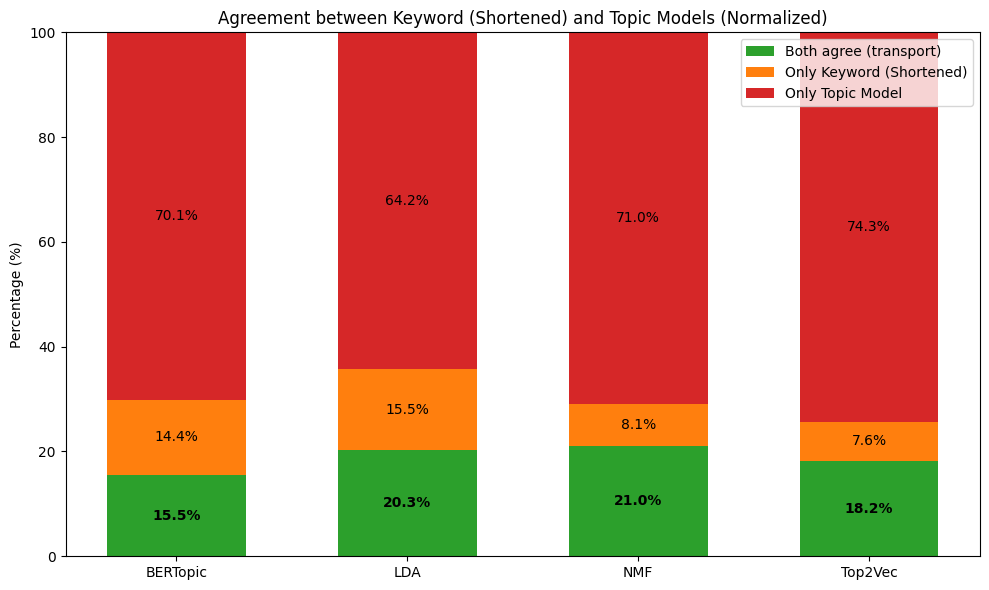

In [34]:
# Prepare data for stacked bar chart (percentages)
pairwise_data = {
    'BERTopic': {'Both': 97, 'Only Keyword': 90, 'Only Model': 439},
    'LDA': {'Both': 106, 'Only Keyword': 81, 'Only Model': 336},
    'NMF': {'Both': 135, 'Only Keyword': 52, 'Only Model': 457},
    'Top2Vec': {'Both': 132, 'Only Keyword': 55, 'Only Model': 540}
}

fig, ax = plt.subplots(figsize=(10, 6))

models = list(pairwise_data.keys())

# Calculate percentages
both_pct = []
only_keyword_pct = []
only_model_pct = []

for m in models:
    total = sum(pairwise_data[m].values())
    both_pct.append((pairwise_data[m]['Both'] / total) * 100)
    only_keyword_pct.append((pairwise_data[m]['Only Keyword'] / total) * 100)
    only_model_pct.append((pairwise_data[m]['Only Model'] / total) * 100)

x = np.arange(len(models))
width = 0.6

p1 = ax.bar(x, both_pct, width, label='Both agree (transport)', color='#2ca02c')
p2 = ax.bar(x, only_keyword_pct, width, bottom=both_pct, label='Only Keyword (Shortened)', color='#ff7f0e')
p3 = ax.bar(x, only_model_pct, width, bottom=np.array(both_pct) + np.array(only_keyword_pct), 
            label='Only Topic Model', color='#d62728')

ax.set_ylabel('Percentage (%)')
ax.set_title('Agreement between Keyword (Shortened) and Topic Models (Normalized)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 100)
ax.legend()

# Add percentage labels
for i, m in enumerate(models):
    ax.text(i, both_pct[i]/2, f'{both_pct[i]:.1f}%', ha='center', va='center', fontweight='bold')
    ax.text(i, both_pct[i] + only_keyword_pct[i]/2, f'{only_keyword_pct[i]:.1f}%', ha='center', va='center')
    ax.text(i, both_pct[i] + only_keyword_pct[i] + only_model_pct[i]/2, f'{only_model_pct[i]:.1f}%', 
            ha='center', va='center')

plt.tight_layout()
plt.show()

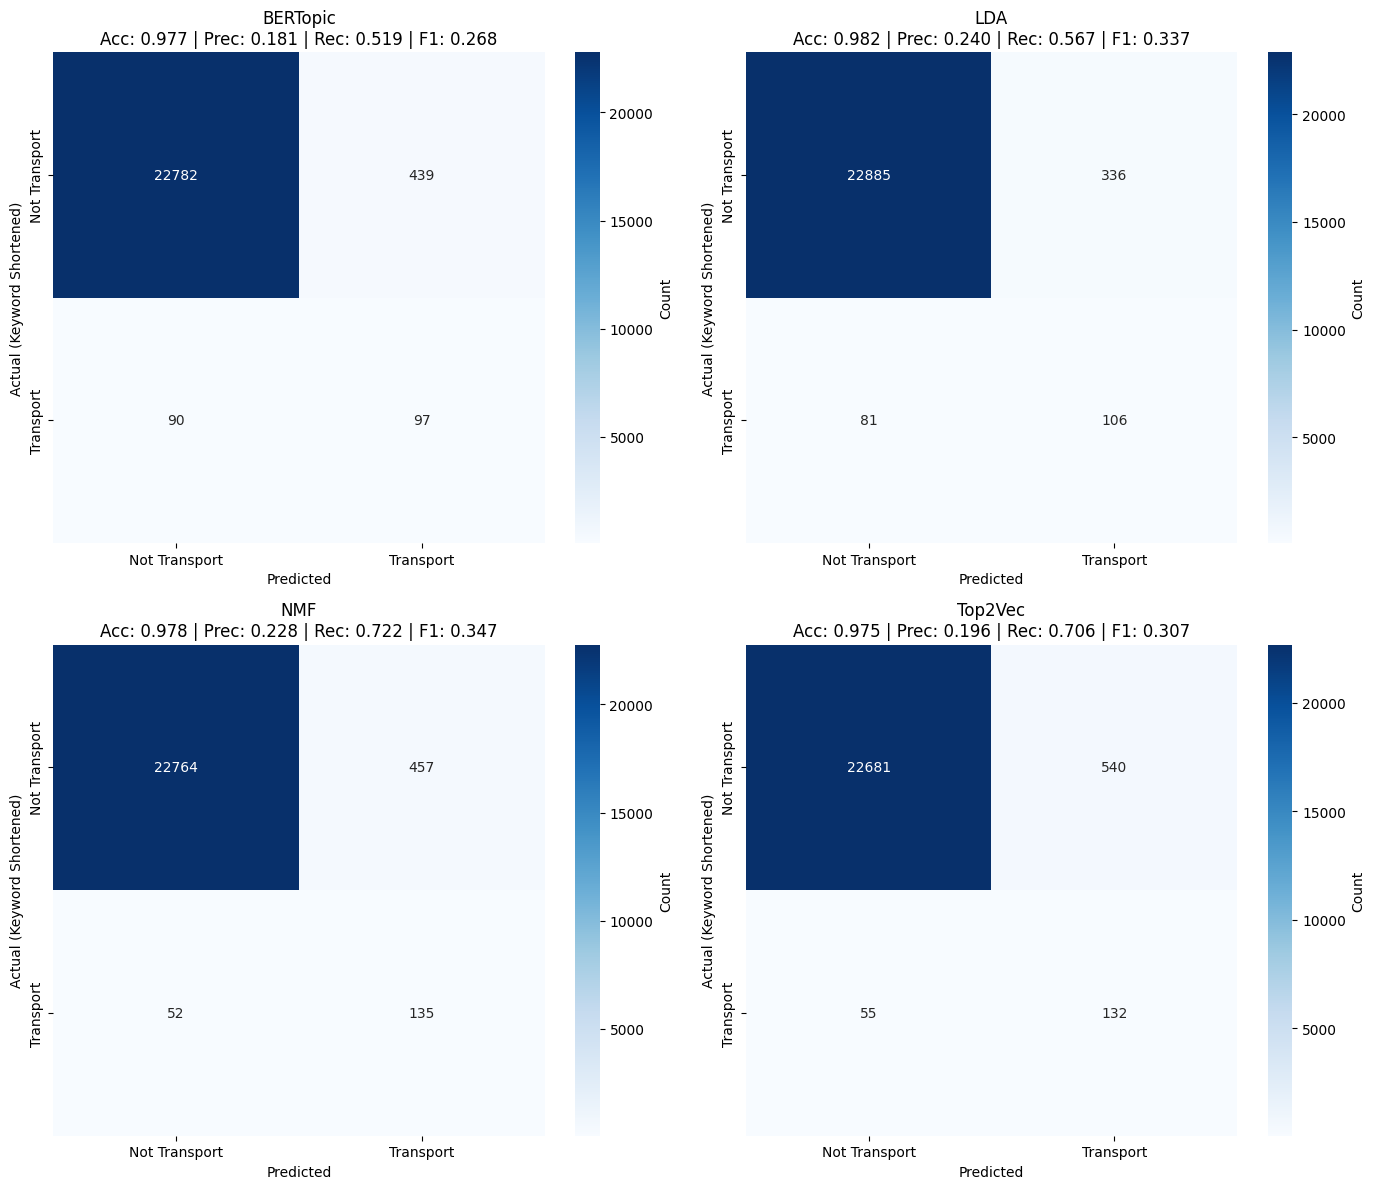

In [37]:
# treat 'is_shortened' as ground truth
# Topic models to evaluate
topic_models = {
    'BERTopic': 'is_bertopic',
    'LDA': 'is_lda',
    'NMF': 'is_nmf',
    'Top2Vec': 'is_top2vec'
}

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (name, col) in enumerate(topic_models.items()):
    cm = confusion_matrix(df['is_shortened'], df[col])
    
    # compute metrics
    accuracy = accuracy_score(df['is_shortened'], df[col])
    precision = precision_score(df['is_shortened'], df[col], zero_division=0)
    recall = recall_score(df['is_shortened'], df[col], zero_division=0)
    f1 = f1_score(df['is_shortened'], df[col], zero_division=0)
    
    # confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Not Transport', 'Transport'],
                yticklabels=['Not Transport', 'Transport'],
                cbar_kws={'label': 'Count'})
    
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual (Keyword Shortened)')
    axes[idx].set_title(f'{name}\nAcc: {accuracy:.3f} | Prec: {precision:.3f} | Rec: {recall:.3f} | F1: {f1:.3f}')

plt.tight_layout()
plt.show()

In [38]:
for name, col in topic_models.items():
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(df['is_shortened'], df[col]).ravel()
    
    # Calculate metrics
    accuracy = accuracy_score(df['is_shortened'], df[col])
    precision = precision_score(df['is_shortened'], df[col], zero_division=0)
    recall = recall_score(df['is_shortened'], df[col], zero_division=0)
    f1 = f1_score(df['is_shortened'], df[col], zero_division=0)
    
    print(f"{name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  TP: {tp:5d} | FP: {fp:5d} | FN: {fn:5d} | TN: {tn:5d}")

BERTopic:
  Accuracy:  0.9774
  Precision: 0.1810
  Recall:    0.5187
  F1-Score:  0.2683
  TP:    97 | FP:   439 | FN:    90 | TN: 22782
LDA:
  Accuracy:  0.9822
  Precision: 0.2398
  Recall:    0.5668
  F1-Score:  0.3370
  TP:   106 | FP:   336 | FN:    81 | TN: 22885
NMF:
  Accuracy:  0.9783
  Precision: 0.2280
  Recall:    0.7219
  F1-Score:  0.3466
  TP:   135 | FP:   457 | FN:    52 | TN: 22764
Top2Vec:
  Accuracy:  0.9746
  Precision: 0.1964
  Recall:    0.7059
  F1-Score:  0.3073
  TP:   132 | FP:   540 | FN:    55 | TN: 22681


### Final Identification of Transport Related Topics

For the final identification of transport-related parliamentary transcripts, a consensus-based approach will be used, with a majority vote across five methodologies: keyword matching (shortened list), BERTopic, LDA, NMF, and Top2Vec. A transcript is classified as transport-related if at least three of the five approaches identify it as such.

This is done to deal with limitations of relying solely on keyword matching, which can miss semantically relevant transport discussions that lack exact keywords. Topic models capture semantic patterns and context that keyword matching may overlook. By requiring agreement from at least three methods, we balance precision with semantic coverage while reducing false positives. Notably, if three or more topic models agree on transport classification even when keyword matching disagrees, the document is still classified as transport-related, recognizing that models may identify relevant content through semantic patterns that keyword matching cannot detect.

In [46]:
approaches_final = ['is_shortened', 'is_bertopic', 'is_lda', 'is_nmf', 'is_top2vec']
df['num_approaches_agree'] = df[approaches_final].sum(axis=1)
df['is_transport'] = df['num_approaches_agree'] >= 3

In [47]:
print("=== Final Transport Classification ===")
print(f"Total documents: {len(df)}")
print(f"Transport documents (≥3 approaches agree): {df['is_transport'].sum()}")
print(f"Percentage: {(df['is_transport'].sum() / len(df)) * 100:.2f}%")

=== Final Transport Classification ===
Total documents: 23408
Transport documents (≥3 approaches agree): 417
Percentage: 1.78%


In [48]:
print("\n=== Distribution by Number of Approaches ===")
for num in range(6):
    count = (df['num_approaches_agree'] == num).sum()
    pct = (count / len(df)) * 100
    print(f"{num} approaches agree: {count:5d} ({pct:.2f}%)")


=== Distribution by Number of Approaches ===
0 approaches agree: 22406 (95.72%)
1 approaches agree:   298 (1.27%)
2 approaches agree:   287 (1.23%)
3 approaches agree:   175 (0.75%)
4 approaches agree:   178 (0.76%)
5 approaches agree:    64 (0.27%)


In [50]:
df[df['is_transport']].head(10)

,date,topic,text,term,clean_text,bertopic_topic,bertopic_prob,is_bertopic,lda_topic,lda_prob,...,is_nmf,top2vec_topic,top2vec_score,is_top2vec,is_full,is_shortened,keywords_full,keywords_shortened,num_approaches_agree,is_transport
63,15-04-1999,4. Transport infrastructure charging,President . – The next item is the report (A4‐...,94_99,schmidbauer transport tourism white paper enti...,64,1.000000,True,19,0.388259,...,True,15,0.826061,True,True,False,"['bus', 'car', 'infrastructure', 'rail', 'road...",[],4,True
65,15-04-1999,6. Transport infrastructure charging (continua...,President . – The next item is the continuatio...,94_99,continuation schmidbauer transport tourism whi...,64,0.914965,True,19,0.485889,...,True,15,0.789501,True,True,False,"['air transport', 'airport', 'car', 'infrastru...",[],4,True
66,15-04-1999,7. Maximum authorised dimensions and weights i...,President . – The next item is the second repo...,94_99,van dam transport tourism directive amending d...,-1,0.000000,False,19,0.487040,...,True,15,0.782774,True,True,False,"['bus', 'car', 'freight transport', 'rail', 'r...",[],3,True
134,10-03-1999,6. VOTES,"Report (A4‐0063/99) by Mrs Hardstaff, on behal...",94_99,hardstaff fisheries communication implementati...,11,0.833863,False,19,0.339341,...,True,16,0.835329,False,True,True,"['air transport', 'airport', 'boat', 'bus', 'c...","['air transport', 'freight transport', 'passen...",3,True
156,09-03-1999,14. Transportable pressure equipment,President . – The next item is the recommendat...,94_99,recommendation transport tourism common positi...,36,0.658336,True,65,0.568049,...,True,15,0.867278,True,False,False,[],[],3,True
157,09-03-1999,15. Ports and intermodal terminals,President . – The next item is the report (A4‐...,94_99,piecyk transport tourism amending ec regards s...,198,0.882641,False,19,0.394937,...,True,42,0.812338,True,True,False,"['airport', 'bus', 'car', 'infrastructure', 'i...",[],3,True
158,09-03-1999,16. Railways,President . – The next item is the joint debat...,94_99,following reports sarlis transport tourism dir...,69,0.527927,True,19,0.535887,...,True,100,0.884851,True,True,True,"['air transport', 'airport', 'bus', 'car', 'fr...","['air transport', 'freight transport', 'passen...",5,True
177,24-02-1999,7. Harmonisation of social legislation on tran...,President . – The next item is the report (A4‐...,94_99,grosch transport tourism transport policy harm...,64,0.862533,True,19,0.352490,...,True,15,0.854463,True,True,True,"['air transport', 'aircraft', 'bus', 'car', 'd...","['air transport', 'inland waterway transport',...",5,True
186,12-02-1999,2. VOTES,"Recommendation (A4‐0013/99) by Mrs Aelvoet, on...",94_99,recommendation aelvoet development cooperation...,36,0.657020,True,19,0.362622,...,True,15,0.860823,True,False,False,[],[],4,True
193,11-02-1999,3. Combined traffic: dimensions and weights,President . – The next item is the report (A4‐...,94_99,van dam transport tourism directive amending d...,-1,0.000000,False,19,0.587579,...,True,15,0.819910,True,True,False,"['car', 'freight transport', 'infrastructure',...",[],3,True


In [57]:
# Count unique dates with transport / non-transport documents
dates_true = set(df.loc[df['is_transport'], 'date'].dropna().unique())
dates_false = set(df.loc[~df['is_transport'], 'date'].dropna().unique())

n_dates_true = len(dates_true)
n_dates_only_false = len(dates_false - dates_true)
n_total_unique_dates = len(set(df['date'].dropna().unique()))

print(f"Unique dates with ≥1 transport doc: {n_dates_true}")
print(f"Unique dates with only non-transport docs: {n_dates_only_false}")
print(f"Total unique dates in dataset: {n_total_unique_dates}")

Unique dates with ≥1 transport doc: 282
Unique dates with only non-transport docs: 1416
Total unique dates in dataset: 1698


In [51]:
# store back to combined_terms_final.csv
# or change name if needed
df.to_csv('data/csv/combined_terms_final.csv')

In [52]:
# save just the transport related documents
transport_final_df = df[df['is_transport']]
transport_final_df.to_csv('data/csv/transport_final.csv')

print(f"Transport documents saved: {len(transport_final_df)} rows")

Transport documents saved: 417 rows
